In [1]:
!pip install pyspark

## PySpark Session Builder

In [1]:
import requests
import json
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, countDistinct, isnull, when
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler, PCA, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor, LinearRegression, DecisionTreeRegressor
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import RegressionEvaluator
import time
import psutil
import os

# Initialize Spark session
spark = SparkSession.builder \
    .appName("Airbnb Data Analysis") \
    .getOrCreate()


In [3]:
start_time = time.time()
start_memory = psutil.virtual_memory().used / (1024 ** 3)
start_cpu = psutil.cpu_percent()

In [2]:
# API Request
url = "https://airbnb-api4.p.rapidapi.com/"

headers = {
    "x-rapidapi-key": "61afcd6139mshf4faadb63a2d0d0p1cc779jsn8297b6dc8463",
    "x-rapidapi-host": "airbnb-api4.p.rapidapi.com"
}

response = requests.get(url, headers=headers)
data = response.json()

# Save JSON data to file
with open('data.json', "w") as f:
    json.dump(data, f)

# Load JSON data into a PySpark DataFrame
df = spark.read.json('data.json')



In [5]:
end_time = time.time()
end_memory = psutil.virtual_memory().used / (1024 ** 3)
end_cpu = psutil.cpu_percent()
json_file_size = os.path.getsize('data.json') / (1024 ** 2)

print(f"Loading time for JSON: {end_time - start_time:.2f} seconds")
print(f"Memory used for loading JSON: {end_memory - start_memory:.2f} GB")
print(f"CPU usage after loading JSON: {end_cpu:.2f}%")
print(f"Size of JSON file: {json_file_size:.2f} MB")

Loading time for JSON: 165.58 seconds
Memory used for loading JSON: 0.37 GB
CPU usage after loading JSON: 26.80%
Size of JSON file: 2.61 MB


## *DF EDA*

In [6]:
# Show schema
df.printSchema()

root
 |-- Accommodation_year: long (nullable = true)
 |-- Amenities: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- Booking_total: double (nullable = true)
 |-- Bookings: long (nullable = true)
 |-- Building type: string (nullable = true)
 |-- Cancellation_Policy: string (nullable = true)
 |-- Commission: double (nullable = true)
 |-- Construction_year: long (nullable = true)
 |-- Currency: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Food_cost: double (nullable = true)
 |-- Food_type: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- Host_Experience: string (nullable = true)
 |-- Host_Revenue: double (nullable = true)
 |-- Host_fee: double (nullable = true)
 |-- Host_identity_verified: string (nullable = true)
 |-- Host_name: string (nullable = true)
 |-- House_rules: string (nullable = true)
 |-- Instant_bookable: string (nullable = true)
 |-- Minimum_nights: long (nullable = true)
 |-- Name: string 

In [7]:
# Show the first few rows
df.show(5)

+------------------+--------------------+-------------+--------+-------------+-------------------+----------+-----------------+--------+--------------------+---------+--------------------+--------------------+------------+--------+----------------------+-----------+--------------------+----------------+--------------+--------------------+--------------------+----------------+-------------+------------------+--------------------+-----------------+------------------+-----------+------+-------------+-------------+-------+-------+-------+
|Accommodation_year|           Amenities|Booking_total|Bookings|Building type|Cancellation_Policy|Commission|Construction_year|Currency|         Description|Food_cost|           Food_type|     Host_Experience|Host_Revenue|Host_fee|Host_identity_verified|  Host_name|         House_rules|Instant_bookable|Minimum_nights|                Name|       Neighbourhood|Platform_Revenue|Property type|Review_rate_number|             Reviews|Reviews_per_month|         

In [8]:
from pyspark.sql.functions import from_unixtime, col

# Convert the timestamp in milliseconds to seconds by dividing by 1000
# Use from_unixtime to convert to timestamp, then extract the year using the year function
df = df.withColumn("Construction_year", from_unixtime(col("Construction_year") / 1000, "yyyy"))

# Show the updated DataFrame with valid years
df.select("Construction_year").show()

+-----------------+
|Construction_year|
+-----------------+
|             2015|
|             2008|
|             2014|
|             2022|
|             2015|
|             2018|
|             2016|
|             2009|
|             2021|
|             2017|
|             2012|
|             2012|
|             2018|
|             2018|
|             2013|
|             2008|
|             2012|
|             2018|
|             2016|
|             2016|
+-----------------+
only showing top 20 rows



In [9]:
# Find minimum and maximum values for Construction_year in PySpark
df.selectExpr("min(Construction_year)", "max(Construction_year)").show()

+----------------------+----------------------+
|min(Construction_year)|max(Construction_year)|
+----------------------+----------------------+
|                  2008|                  2022|
+----------------------+----------------------+



In [10]:
# Summary statistics
df.describe().show()

+-------+--------------------+-----------------+-----------------+-------------+-------------------+--------------------+-----------------+--------+--------------------+------------------+--------------------+------------------+-------------------+----------------------+---------+--------------------+----------------+------------------+-------------------+------------------+-----------------+--------------+------------------+--------------------+------------------+------------------+-------------------+-------+-------------+------------------+-----------------+------------------+------------------+
|summary|  Accommodation_year|    Booking_total|         Bookings|Building type|Cancellation_Policy|          Commission|Construction_year|Currency|         Description|         Food_cost|     Host_Experience|      Host_Revenue|           Host_fee|Host_identity_verified|Host_name|         House_rules|Instant_bookable|    Minimum_nights|               Name|     Neighbourhood| Platform_Revenue

In [11]:
start_time = time.time()
start_memory = psutil.virtual_memory().used / (1024 ** 3)
start_cpu = psutil.cpu_percent()

In [12]:
# Count of missing values per column
missing_values_df = df.select([count(when(isnull(c), c)).alias(c) for c in df.columns])
missing_values_df.show()

+------------------+---------+-------------+--------+-------------+-------------------+----------+-----------------+--------+-----------+---------+---------+---------------+------------+--------+----------------------+---------+-----------+----------------+--------------+----+-------------+----------------+-------------+------------------+-------+-----------------+------+-----------+-----+------+-------------+-------+-------+---+
|Accommodation_year|Amenities|Booking_total|Bookings|Building type|Cancellation_Policy|Commission|Construction_year|Currency|Description|Food_cost|Food_type|Host_Experience|Host_Revenue|Host_fee|Host_identity_verified|Host_name|House_rules|Instant_bookable|Minimum_nights|Name|Neighbourhood|Platform_Revenue|Property type|Review_rate_number|Reviews|Reviews_per_month|Season|Service_fee|State|Status|Total_Revenue|Zipcode|host_id| id|
+------------------+---------+-------------+--------+-------------+-------------------+----------+-----------------+--------+-------

In [13]:
# Check for duplicates
duplicates_df = df.groupBy(df.columns).count().filter("count > 1")
duplicates_df.show()

+------------------+---------+-------------+--------+-------------+-------------------+----------+-----------------+--------+-----------+---------+---------+---------------+------------+--------+----------------------+---------+-----------+----------------+--------------+----+-------------+----------------+-------------+------------------+-------+-----------------+------+-----------+-----+------+-------------+-------+-------+---+-----+
|Accommodation_year|Amenities|Booking_total|Bookings|Building type|Cancellation_Policy|Commission|Construction_year|Currency|Description|Food_cost|Food_type|Host_Experience|Host_Revenue|Host_fee|Host_identity_verified|Host_name|House_rules|Instant_bookable|Minimum_nights|Name|Neighbourhood|Platform_Revenue|Property type|Review_rate_number|Reviews|Reviews_per_month|Season|Service_fee|State|Status|Total_Revenue|Zipcode|host_id| id|count|
+------------------+---------+-------------+--------+-------------+-------------------+----------+-----------------+----

In [14]:
df = df.dropna()

In [15]:
end_time = time.time()
end_memory = psutil.virtual_memory().used / (1024 ** 3)
end_cpu = psutil.cpu_percent()

print(f"Processing time: {end_time - start_time:.2f} seconds")
print(f"Memory used for data processing: {end_memory - start_memory:.2f} GB")
print(f"CPU usage after data processing: {end_cpu:.2f}%")

Processing time: 5.70 seconds
Memory used for data processing: 0.01 GB
CPU usage after data processing: 100.00%


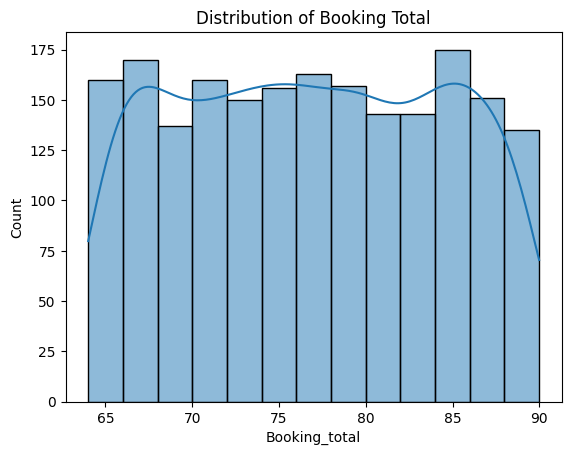

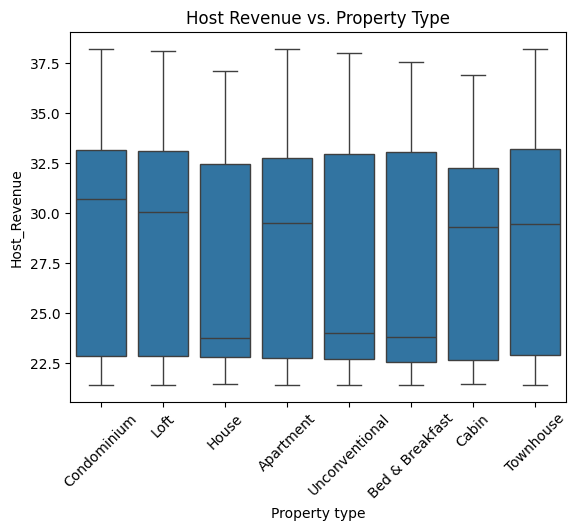

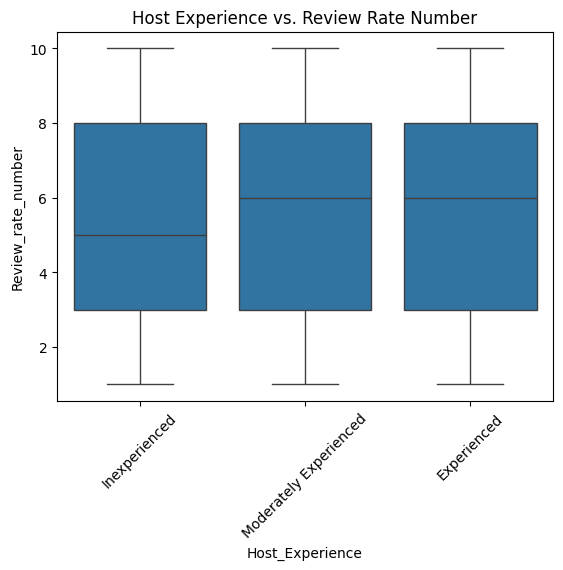

+-----------------+---------------------+
|Construction_year|Mean_Platform_Revenue|
+-----------------+---------------------+
|             2008|    8.484583561643838|
|             2009|     8.05295106382979|
|             2010|    8.357214049586782|
|             2011|    7.381170676691728|
|             2012|    8.286933333333346|
|             2013|    7.427806299212599|
|             2014|    8.864697540983602|
|             2015|    7.470446218487395|
|             2016|    9.027260330578518|
|             2017|     7.97043857142857|
|             2018|    7.695569531250001|
|             2019|    8.687422556390972|
|             2020|    8.276510071942447|
|             2021|    8.011946511627904|
|             2022|    8.275344604316548|
+-----------------+---------------------+



<ipython-input-16-5a957b8513e2>:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Construction_year", y="Mean_Platform_Revenue", data=grouped_df_pandas, palette="Blues_d")


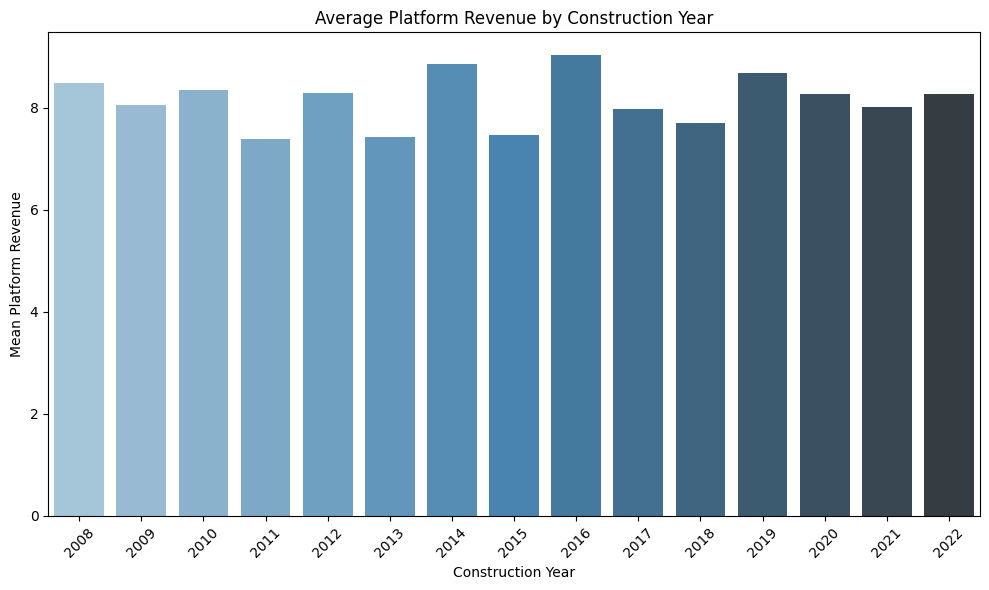

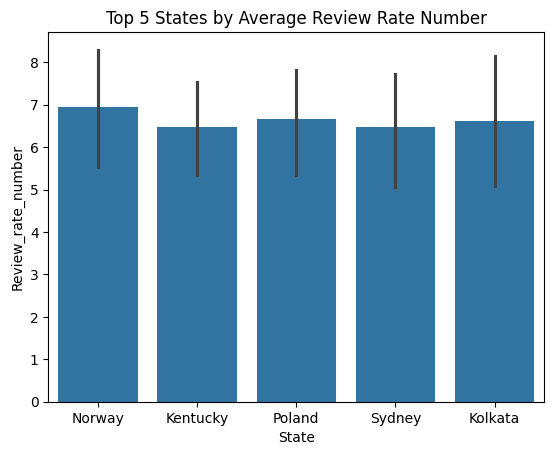

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert PySpark DataFrame to Pandas
df_pandas = df.toPandas()

# 1. Distribution of Booking Total
sns.histplot(df_pandas['Booking_total'], kde=True)
plt.title('Distribution of Booking Total')
plt.show()

# 2. Host Revenue vs. Property Type
sns.boxplot(x='Property type', y='Host_Revenue', data=df_pandas)
plt.title('Host Revenue vs. Property Type')
plt.xticks(rotation=45)
plt.show()

# 3. Host Experience vs. Review Rate Number
sns.boxplot(x='Host_Experience', y='Review_rate_number', data=df_pandas)
plt.title('Host Experience vs. Review Rate Number')
plt.xticks(rotation=45)
plt.show()

# 4. Platform Revenue vs. Construction Year
# Group by 'Construction_year' and calculate the mean of 'Platform_Revenue'
grouped_df = df.groupBy("Construction_year").agg({"Platform_Revenue": "mean"})

grouped_df = grouped_df.withColumnRenamed("avg(Platform_Revenue)", "Mean_Platform_Revenue")

grouped_df = grouped_df.orderBy("Construction_year")

# Convert to Pandas for plotting
grouped_df_pandas = grouped_df.toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(x="Construction_year", y="Mean_Platform_Revenue", data=grouped_df_pandas, palette="Blues_d")
plt.title("Average Platform Revenue by Construction Year")
plt.xlabel("Construction Year")
plt.ylabel("Mean Platform Revenue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# 5. Average Review Rate Number by State
avg_review_rate_by_state = df_pandas.groupby('State')['Review_rate_number'].mean().sort_values(ascending=False).head(5)

# Filter the DataFrame to include only the top 5 states
top_states_df = df_pandas[df_pandas['State'].isin(avg_review_rate_by_state.index)]

# Plot
sns.barplot(x='State', y='Review_rate_number', data=top_states_df, estimator=lambda x: sum(x)/len(x))
plt.title('Top 5 States by Average Review Rate Number')
plt.show()

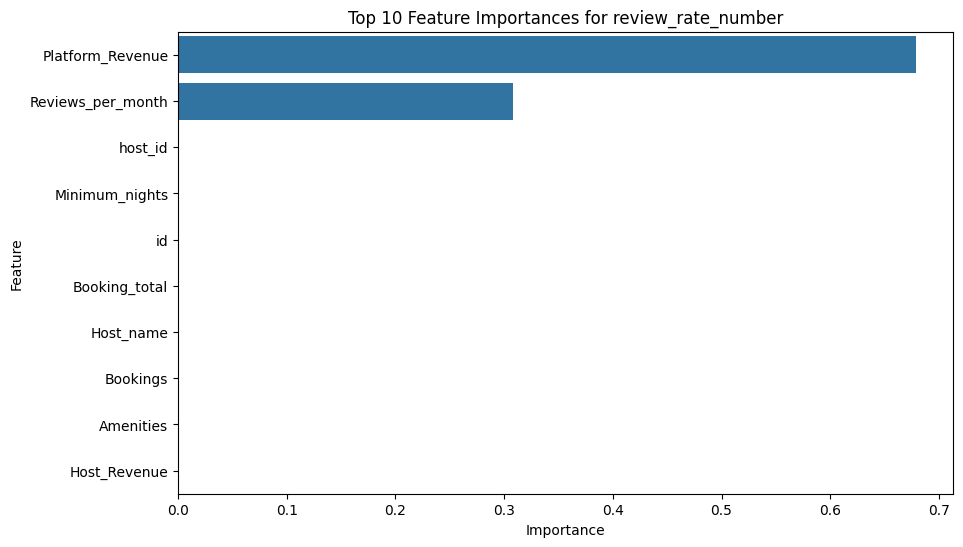

In [17]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Convert columns with list/array data types to strings
df_pandas['Amenities'] = df_pandas['Amenities'].apply(lambda x: ', '.join(x) if isinstance(x, list) else str(x))
df_pandas['Food_type'] = df_pandas['Food_type'].apply(lambda x: ', '.join(x) if isinstance(x, list) else str(x))

# Drop rows with missing target variable
df_pandas = df_pandas.dropna(subset=['Review_rate_number'])

# Separate features and target variable
X_df = df_pandas.drop(columns=['Review_rate_number'])
y_df = df_pandas['Review_rate_number']

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Apply Label Encoding to each categorical column
for column in X_df.select_dtypes(include=['object']).columns:
    X_df[column] = label_encoder.fit_transform(X_df[column].astype(str))

# Fill missing values with 0 (or any other appropriate value)
#X_df.fillna(0, inplace=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.3, random_state=42)

# Train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Get feature importance
feature_importances_df = rf_model.feature_importances_

# Create a DataFrame to display feature importances
importance_df = pd.DataFrame({'Feature': X_df.columns, 'Importance': feature_importances_df})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))
plt.title('Top 10 Feature Importances for review_rate_number')
plt.show()


In [18]:
# Filter the top 5 features
top_5_features = importance_df.head(5)['Feature'].tolist()
top_5_features.append('Host_name')

# Keep only the top 5 features in df
df = df_pandas[top_5_features + ['Review_rate_number']]


## *DF2 EDA*

In [19]:
start_time = time.time()
start_memory = psutil.virtual_memory().used / (1024 ** 3)
start_cpu = psutil.cpu_percent()

# Load the CSV file into a PySpark DataFrame
df2 = spark.read.csv('/content/AB_US_2020.csv', header=True, inferSchema=True)

end_time = time.time()
end_memory = psutil.virtual_memory().used / (1024 ** 3)
end_cpu = psutil.cpu_percent()
csv_file_size = os.path.getsize('/content/AB_US_2020.csv') / (1024 ** 2)

print(f"Loading time for CSV: {end_time - start_time:.2f} seconds")
print(f"Memory used for loading CSV: {end_memory - start_memory:.2f} GB")
print(f"CPU usage after loading CSV: {end_cpu:.2f}%")
print(f"Size of CSV file: {csv_file_size:.2f} MB")

Loading time for CSV: 5.96 seconds
Memory used for loading CSV: 0.03 GB
CPU usage after loading CSV: 99.90%
Size of CSV file: 34.41 MB


In [20]:
# Show schema
df2.printSchema()

root
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- host_id: string (nullable = true)
 |-- host_name: string (nullable = true)
 |-- neighbourhood_group: string (nullable = true)
 |-- neighbourhood: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- price: string (nullable = true)
 |-- minimum_nights: string (nullable = true)
 |-- number_of_reviews: string (nullable = true)
 |-- last_review: string (nullable = true)
 |-- reviews_per_month: string (nullable = true)
 |-- calculated_host_listings_count: string (nullable = true)
 |-- availability_365: string (nullable = true)
 |-- city: string (nullable = true)



In [21]:
# Show the first few rows
df2.show(5)

+------+--------------------+-------+---------+-------------------+-------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+---------+
|    id|                name|host_id|host_name|neighbourhood_group|neighbourhood|latitude|longitude|      room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|     city|
+------+--------------------+-------+---------+-------------------+-------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+---------+
| 38585|Charming Victoria...| 165529|  Evelyne|               NULL|        28804|35.65146|-82.62792|   Private room|   60|             1|              138|   16/02/20|             1.14|                             1|               0|Asheville|
| 80905|    French Chic 

In [22]:
# Summary statistics
df2.describe().show()

+-------+--------------------+--------------------+-------------------+--------------+-------------------+--------------------+------------------+------------------+--------------------+-----------------+------------------+------------------+------------------+------------------+------------------------------+------------------+------------------+
|summary|                  id|                name|            host_id|     host_name|neighbourhood_group|       neighbourhood|          latitude|         longitude|           room_type|            price|    minimum_nights| number_of_reviews|       last_review| reviews_per_month|calculated_host_listings_count|  availability_365|              city|
+-------+--------------------+--------------------+-------------------+--------------+-------------------+--------------------+------------------+------------------+--------------------+-----------------+------------------+------------------+------------------+------------------+--------------------

In [23]:
start_time = time.time()
start_memory = psutil.virtual_memory().used / (1024 ** 3)
start_cpu = psutil.cpu_percent()

In [24]:
# Count of missing values per column
missing_values_df2 = df2.select([count(when(isnull(c), c)).alias(c) for c in df2.columns])
missing_values_df2.show()

+---+----+-------+---------+-------------------+-------------+--------+---------+---------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+----+
| id|name|host_id|host_name|neighbourhood_group|neighbourhood|latitude|longitude|room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|city|
+---+----+-------+---------+-------------------+-------------+--------+---------+---------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+----+
|  0|  93|    695|      995|             116213|          738|     718|      700|      698|  698|           698|              782|      49281|            49207|                           713|             703|1275|
+---+----+-------+---------+-------------------+-------------+--------+---------+---------+-----+--------------+-----------------+-----------+--

In [25]:
# Check for duplicates
duplicates_df2 = df2.groupBy(df2.columns).count().filter("count > 1")
duplicates_df2.show()

+--------------------+----+-------+---------+-------------------+-------------+--------+---------+---------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+----+-----+
|                  id|name|host_id|host_name|neighbourhood_group|neighbourhood|latitude|longitude|room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|city|count|
+--------------------+----+-------+---------+-------------------+-------------+--------+---------+---------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+----+-----+
|   * Newly Remodeled|NULL|   NULL|     NULL|               NULL|         NULL|    NULL|     NULL|     NULL| NULL|          NULL|             NULL|       NULL|             NULL|                          NULL|            NULL|NULL|    2|
|               SoBro|NULL|   NULL|     NULL|       

In [26]:
df2 = df2.dropna()

missing_values_df2 = df2.select([count(when(isnull(c), c)).alias(c) for c in df2.columns])
missing_values_df2.show()

+---+----+-------+---------+-------------------+-------------+--------+---------+---------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+----+
| id|name|host_id|host_name|neighbourhood_group|neighbourhood|latitude|longitude|room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|city|
+---+----+-------+---------+-------------------+-------------+--------+---------+---------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+----+
|  0|   0|      0|        0|                  0|            0|       0|        0|        0|    0|             0|                0|          0|                0|                             0|               0|   0|
+---+----+-------+---------+-------------------+-------------+--------+---------+---------+-----+--------------+-----------------+-----------+--

In [27]:
end_time = time.time()
end_memory = psutil.virtual_memory().used / (1024 ** 3)
end_cpu = psutil.cpu_percent()

print(f"Processing time: {end_time - start_time:.2f} seconds")
print(f"Memory used for data processing: {end_memory - start_memory:.2f} GB")
print(f"CPU usage after data processing: {end_cpu:.2f}%")

Processing time: 21.78 seconds
Memory used for data processing: 0.13 GB
CPU usage after data processing: 99.90%


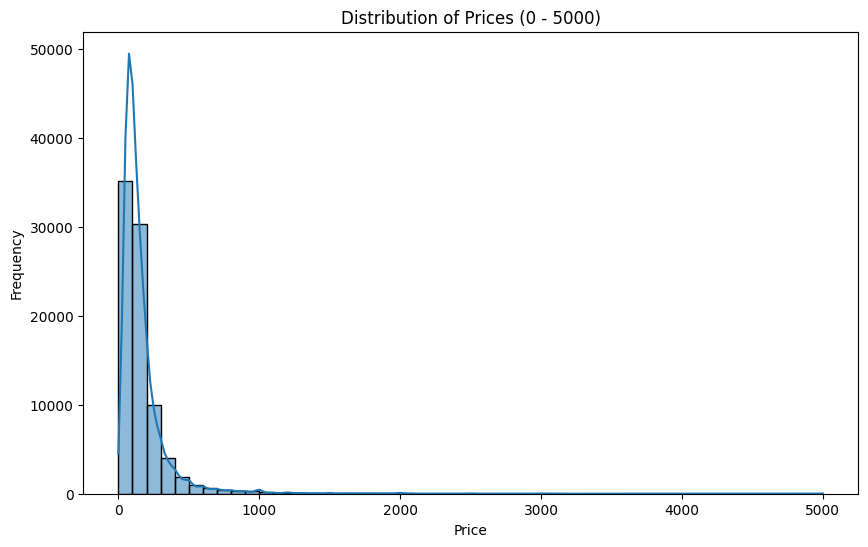

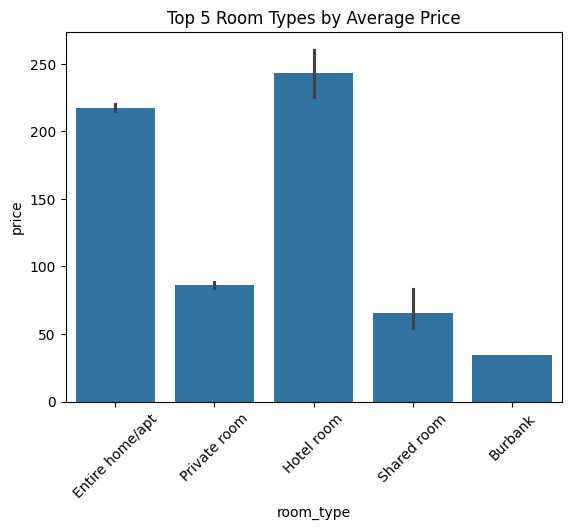

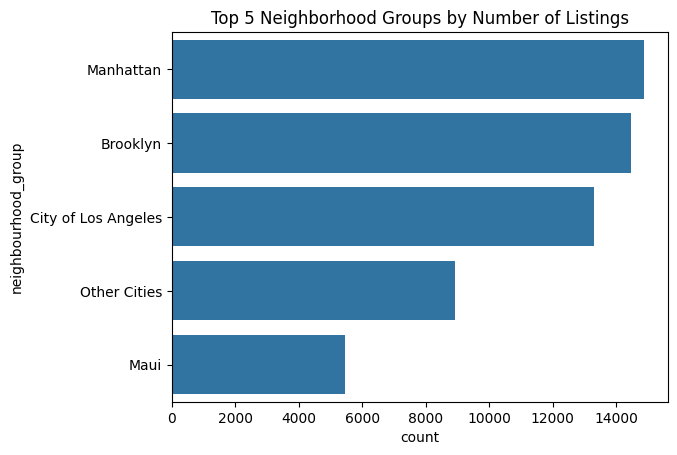

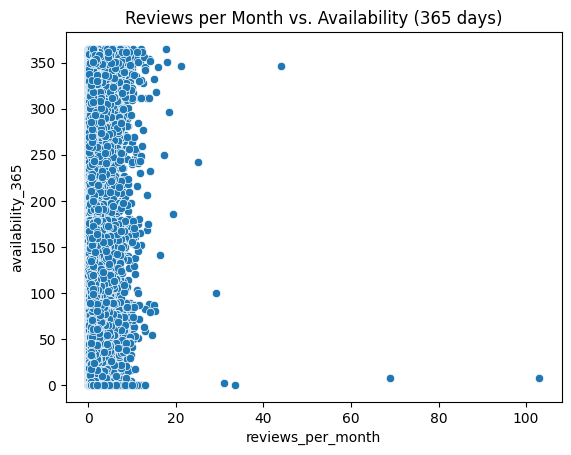

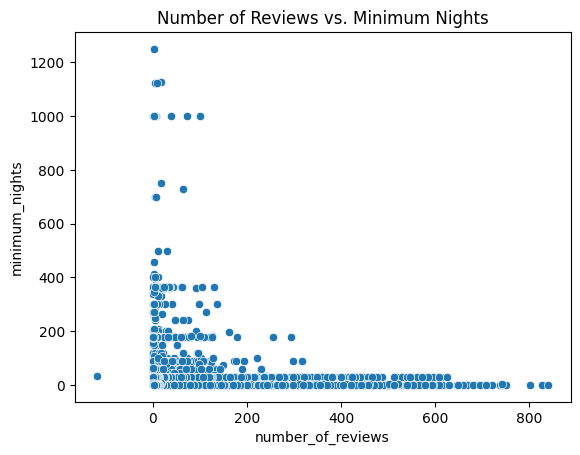

In [28]:
# Convert PySpark DataFrame to Pandas
df2_pandas = df2.toPandas()

# 1. Distribution of Price
df2_pandas['price'] = pd.to_numeric(df2_pandas['price'], errors='coerce')
# Filter the prices between 0 and 5000
filtered_prices = df2_pandas[(df2_pandas['price'] >= 0) & (df2_pandas['price'] <= 5000)]
# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(filtered_prices['price'], bins=50, kde=True)
plt.title('Distribution of Prices (0 - 5000)')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

# 2. Room Type vs. Price
df2_pandas['price'] = pd.to_numeric(df2_pandas['price'], errors='coerce')
# Compute the average price by room type
avg_price_by_room_type = df2_pandas.groupby('room_type')['price'].mean().sort_values(ascending=False).head(5)
# Filter the DataFrame to include only the top 5 room types
top_room_types_df = df2_pandas[df2_pandas['room_type'].isin(avg_price_by_room_type.index)]
# Plot
sns.barplot(x='room_type', y='price', data=top_room_types_df)
plt.title('Top 5 Room Types by Average Price')
plt.xticks(rotation=45)
plt.show()

# 3. Neighbourhood Group Analysis
listings_by_neighborhood_group = df2_pandas['neighbourhood_group'].value_counts().head(5)
# Filter the DataFrame to include only the top 5 neighborhood groups
top_neighborhood_groups_df = df2_pandas[df2_pandas['neighbourhood_group'].isin(listings_by_neighborhood_group.index)]
# Plot
sns.countplot(y='neighbourhood_group', data=top_neighborhood_groups_df, order=listings_by_neighborhood_group.index)
plt.title('Top 5 Neighborhood Groups by Number of Listings')
plt.show()

# 4. Reviews per Month vs. Availability
df2_pandas['reviews_per_month'] = pd.to_numeric(df2_pandas['reviews_per_month'], errors='coerce')
df2_pandas['availability_365'] = pd.to_numeric(df2_pandas['availability_365'], errors='coerce')
sns.scatterplot(x='reviews_per_month', y='availability_365', data=df2_pandas)
plt.title('Reviews per Month vs. Availability (365 days)')
plt.show()

# 5. Number of Reviews vs. Minimum Nights
df2_pandas['number_of_reviews'] = pd.to_numeric(df2_pandas['number_of_reviews'], errors='coerce')
df2_pandas['minimum_nights'] = pd.to_numeric(df2_pandas['minimum_nights'], errors='coerce')
sns.scatterplot(x='number_of_reviews', y='minimum_nights', data=df2_pandas)
plt.title('Number of Reviews vs. Minimum Nights')
plt.show()


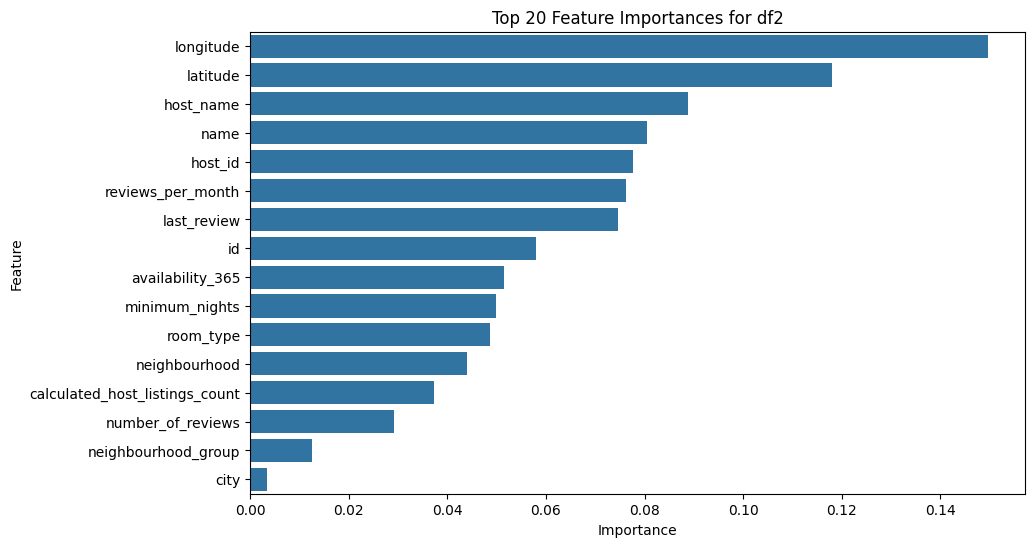

In [29]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert 'price' to numeric and drop rows with missing target values
df2_pandas['price'] = pd.to_numeric(df2_pandas['price'], errors='coerce')
df2_pandas = df2_pandas.dropna(subset=['price'])

# Separate features and target variable
X_df2 = df2_pandas.drop(columns=['price'])
y_df2 = df2_pandas['price']

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Apply Label Encoding to each categorical column
for column in X_df2.select_dtypes(include=['object']).columns:
    X_df2[column] = label_encoder.fit_transform(X_df2[column].astype(str))

# Fill missing values with 0 (or any other appropriate value)
X_df2.fillna(0, inplace=True)

# Split the data into training and testing sets
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_df2, y_df2, test_size=0.3, random_state=42)

# Train a Random Forest model
rf_model2 = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model2.fit(X_train2, y_train2)

# Get feature importance
feature_importances_df2 = rf_model2.feature_importances_

# Create a DataFrame to display feature importances
importance_df2 = pd.DataFrame({'Feature': X_df2.columns, 'Importance': feature_importances_df2})
importance_df2 = importance_df2.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df2.head(20))
plt.title('Top 20 Feature Importances for df2')
plt.show()


In [30]:
features_to_keep = [
    'longitude', 'latitude', 'host_name', 'name', 'host_id',
    'reviews_per_month', 'last_review', 'id', 'availability_365',
    'minimum_nights', 'room_type', 'neighbourhood',
    'calculated_host_listings_count', 'number_of_reviews',
    'neighbourhood_group', 'city'
]

# Filter df2 to keep only these features
df2 = df2[features_to_keep]

## *DF1 & DF2 Merging*

In [31]:
# Convert Pandas DataFrames to PySpark DataFrames
df = spark.createDataFrame(df)

In [32]:
start_time = time.time()
start_memory = psutil.virtual_memory().used / (1024 ** 3)
start_cpu = psutil.cpu_percent()

In [33]:
# Convert all column names to lowercase to make them uniform
df = df.select([col(c).alias(c.lower()) for c in df.columns])
df2 = df2.select([col(c).alias(c.lower()) for c in df2.columns])

# Manually rename columns if needed (based on your original Pandas code)
df = df.withColumnRenamed('name', 'name') \
       .withColumnRenamed('host_name', 'host_name') \
       .withColumnRenamed('neighbourhood', 'neighbourhood') \
       .withColumnRenamed('minimum_nights', 'minimum_nights') \
       .withColumnRenamed('reviews_per_month', 'reviews_per_month')


In [34]:
df2 = df2.select([F.col(col).alias(f"df2_{col}") for col in df2.columns])

In [35]:
print(df.columns)
print(df2.columns)

['platform_revenue', 'reviews_per_month', 'host_id', 'minimum_nights', 'id', 'host_name', 'review_rate_number']
['df2_longitude', 'df2_latitude', 'df2_host_name', 'df2_name', 'df2_host_id', 'df2_reviews_per_month', 'df2_last_review', 'df2_id', 'df2_availability_365', 'df2_minimum_nights', 'df2_room_type', 'df2_neighbourhood', 'df2_calculated_host_listings_count', 'df2_number_of_reviews', 'df2_neighbourhood_group', 'df2_city']


In [36]:
merged_df = df.join(df2, df["host_name"] == df2["df2_host_name"], "inner")


In [37]:
print(f"Model training time: {end_time - start_time:.2f} seconds")
print(f"Memory used for model training: {end_memory - start_memory:.2f} GB")
print(f"CPU usage after model training: {end_cpu:.2f}%")

Model training time: -148.27 seconds
Memory used for model training: -0.70 GB
CPU usage after model training: 99.90%


In [38]:
# Sample the data to avoid memory issues
sample_fraction = 0.1  # Adjust the fraction as needed (e.g., 10% of the data)
merged_df = merged_df.sample(fraction=sample_fraction, seed=42)

In [39]:
merged_df.summary().show()

+-------+-----------------+------------------+-----------------+------------------+-----------------+---------+------------------+-------------------+------------------+-------------+--------------------+-------------------+---------------------+---------------+--------------------+--------------------+------------------+---------------+-----------------+----------------------------------+---------------------+-----------------------+--------+
|summary| platform_revenue| reviews_per_month|          host_id|    minimum_nights|               id|host_name|review_rate_number|      df2_longitude|      df2_latitude|df2_host_name|            df2_name|        df2_host_id|df2_reviews_per_month|df2_last_review|              df2_id|df2_availability_365|df2_minimum_nights|  df2_room_type|df2_neighbourhood|df2_calculated_host_listings_count|df2_number_of_reviews|df2_neighbourhood_group|df2_city|
+-------+-----------------+------------------+-----------------+------------------+-----------------+---

In [40]:
merged_df.printSchema()


root
 |-- platform_revenue: double (nullable = true)
 |-- reviews_per_month: double (nullable = true)
 |-- host_id: long (nullable = true)
 |-- minimum_nights: long (nullable = true)
 |-- id: long (nullable = true)
 |-- host_name: string (nullable = true)
 |-- review_rate_number: long (nullable = true)
 |-- df2_longitude: string (nullable = true)
 |-- df2_latitude: string (nullable = true)
 |-- df2_host_name: string (nullable = true)
 |-- df2_name: string (nullable = true)
 |-- df2_host_id: string (nullable = true)
 |-- df2_reviews_per_month: string (nullable = true)
 |-- df2_last_review: string (nullable = true)
 |-- df2_id: string (nullable = true)
 |-- df2_availability_365: string (nullable = true)
 |-- df2_minimum_nights: string (nullable = true)
 |-- df2_room_type: string (nullable = true)
 |-- df2_neighbourhood: string (nullable = true)
 |-- df2_calculated_host_listings_count: string (nullable = true)
 |-- df2_number_of_reviews: string (nullable = true)
 |-- df2_neighbourhood_gro

In [41]:
# Check the number of rows and columns
print(f"Number of rows: {merged_df.count()}")
print(f"Number of columns: {len(merged_df.columns)}")


Number of rows: 13411
Number of columns: 23


In [42]:
# Assuming you have a PySpark DataFrame named `df`
column_names = merged_df.columns

# Print the column names
print(column_names)


['platform_revenue', 'reviews_per_month', 'host_id', 'minimum_nights', 'id', 'host_name', 'review_rate_number', 'df2_longitude', 'df2_latitude', 'df2_host_name', 'df2_name', 'df2_host_id', 'df2_reviews_per_month', 'df2_last_review', 'df2_id', 'df2_availability_365', 'df2_minimum_nights', 'df2_room_type', 'df2_neighbourhood', 'df2_calculated_host_listings_count', 'df2_number_of_reviews', 'df2_neighbourhood_group', 'df2_city']


In [43]:
merged_df = merged_df.dropDuplicates()

In [44]:
merged_df.dtypes

[('platform_revenue', 'double'),
 ('reviews_per_month', 'double'),
 ('host_id', 'bigint'),
 ('minimum_nights', 'bigint'),
 ('id', 'bigint'),
 ('host_name', 'string'),
 ('review_rate_number', 'bigint'),
 ('df2_longitude', 'string'),
 ('df2_latitude', 'string'),
 ('df2_host_name', 'string'),
 ('df2_name', 'string'),
 ('df2_host_id', 'string'),
 ('df2_reviews_per_month', 'string'),
 ('df2_last_review', 'string'),
 ('df2_id', 'string'),
 ('df2_availability_365', 'string'),
 ('df2_minimum_nights', 'string'),
 ('df2_room_type', 'string'),
 ('df2_neighbourhood', 'string'),
 ('df2_calculated_host_listings_count', 'string'),
 ('df2_number_of_reviews', 'string'),
 ('df2_neighbourhood_group', 'string'),
 ('df2_city', 'string')]

##*Feature Importance and Machine Learning*


In [45]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

# List of columns to drop (numeric columns)
columns_to_drop = ['platform_revenue', 'reviews_per_month', 'minimum_nights', 'id', 'review_rate_number']

# Get the list of categorical columns by dropping numerical columns
categorical_columns = [col for col in merged_df.columns if col not in columns_to_drop]

# StringIndexer for categorical columns
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_index") for col in categorical_columns]

# OneHotEncoder for indexed columns
encoders = [OneHotEncoder(inputCol=f"{col}_index", outputCol=f"{col}_ohe") for col in categorical_columns]

# Create a pipeline for indexing and encoding
pipeline = Pipeline(stages=indexers + encoders)

# Fit the pipeline and transform the data
pipeline_model = pipeline.fit(merged_df)
encoded_df = pipeline_model.transform(merged_df)

# Drop the original categorical columns and indexed columns
drop_columns = categorical_columns + [f"{col}_index" for col in categorical_columns]
encoded_df = encoded_df.drop(*drop_columns)

# Show the result
encoded_df.show()


+----------------+-----------------+--------------+-------+------------------+------------------+----------------+-------------------+-------------------+-----------------+-------------------+-------------------+-------------------------+-------------------+-------------------+------------------------+----------------------+-----------------+---------------------+--------------------------------------+-------------------------+---------------------------+-------------+
|platform_revenue|reviews_per_month|minimum_nights|     id|review_rate_number|       host_id_ohe|   host_name_ohe|  df2_longitude_ohe|   df2_latitude_ohe|df2_host_name_ohe|       df2_name_ohe|    df2_host_id_ohe|df2_reviews_per_month_ohe|df2_last_review_ohe|         df2_id_ohe|df2_availability_365_ohe|df2_minimum_nights_ohe|df2_room_type_ohe|df2_neighbourhood_ohe|df2_calculated_host_listings_count_ohe|df2_number_of_reviews_ohe|df2_neighbourhood_group_ohe| df2_city_ohe|
+----------------+-----------------+--------------+-

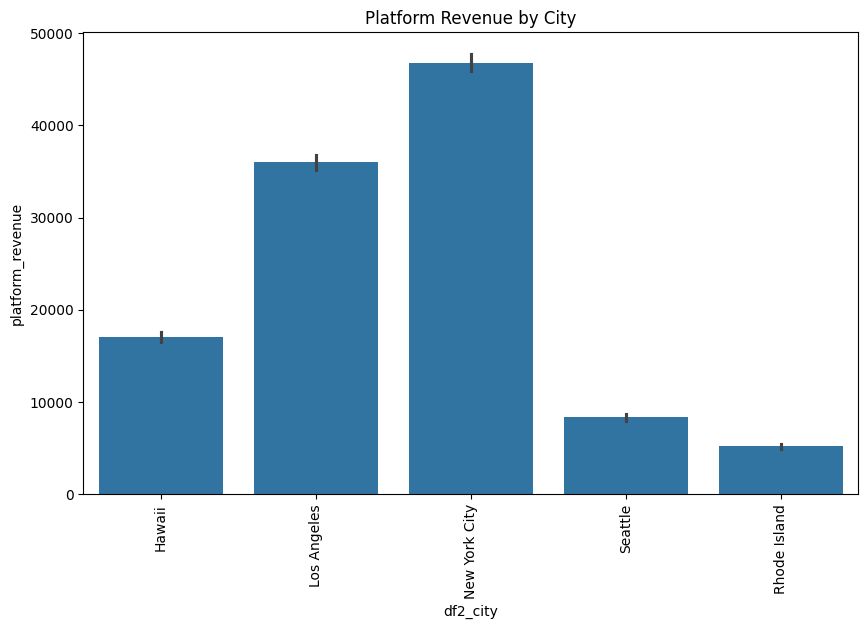

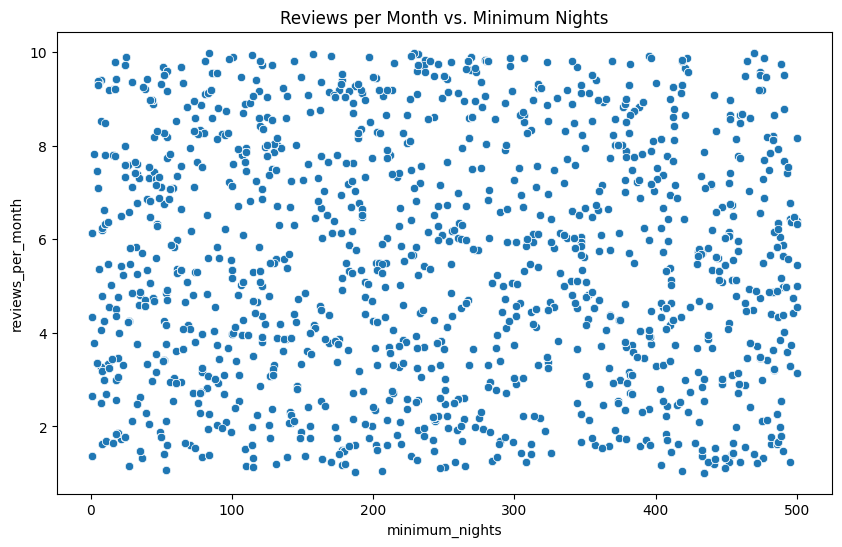

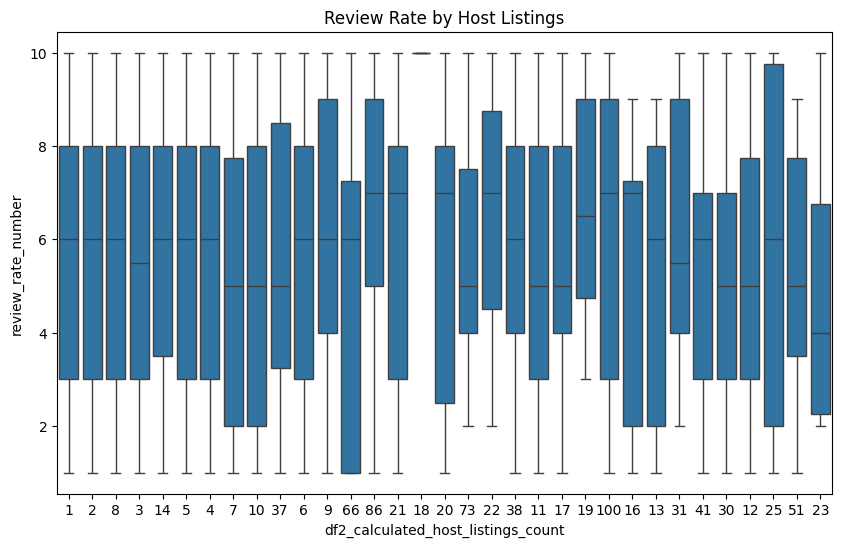

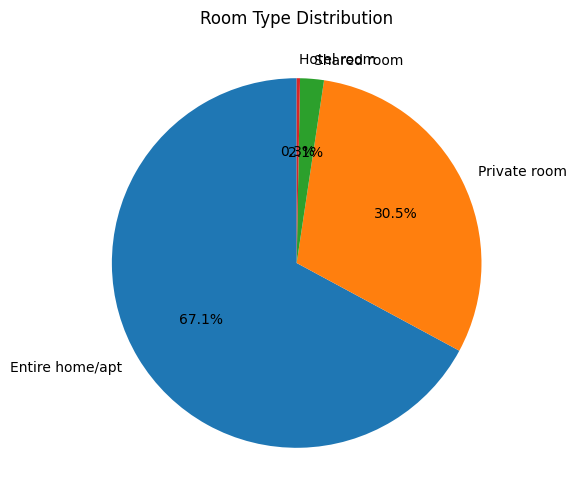

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert necessary columns from PySpark DataFrame to Pandas for visualization
merged_df_pd = merged_df.select(
    'platform_revenue',
    'reviews_per_month',
    'minimum_nights',
    'df2_neighbourhood',
    'df2_city',
    'df2_longitude',
    'df2_latitude',
    'review_rate_number',
    'df2_calculated_host_listings_count',
    'df2_availability_365',
    'df2_room_type',
    'df2_reviews_per_month'
).toPandas()

# 1. Platform Revenue by Neighbourhood or City
plt.figure(figsize=(10, 6))
sns.barplot(x='df2_city', y='platform_revenue', data=merged_df_pd, estimator=sum)
plt.xticks(rotation=90)
plt.title('Platform Revenue by City')
plt.show()

# 2. Reviews per Month vs. Minimum Nights
plt.figure(figsize=(10, 6))
sns.scatterplot(x='minimum_nights', y='reviews_per_month', data=merged_df_pd)
plt.title('Reviews per Month vs. Minimum Nights')
plt.show()

# 3. Host Listings and Review Rate Distribution
plt.figure(figsize=(10, 6))
sns.boxplot(x='df2_calculated_host_listings_count', y='review_rate_number', data=merged_df_pd)
plt.title('Review Rate by Host Listings')
plt.show()

# 4. Room Type Popularity
plt.figure(figsize=(8, 6))
merged_df_pd['df2_room_type'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Room Type Distribution')
plt.ylabel('')
plt.show()




In [47]:
!pip install shap

In [48]:
# Sample the data to avoid memory issues
sample_fraction = 0.1  # Adjust the fraction as needed (e.g., 10% of the data)
encoded_df = encoded_df.sample(fraction=sample_fraction, seed=42)

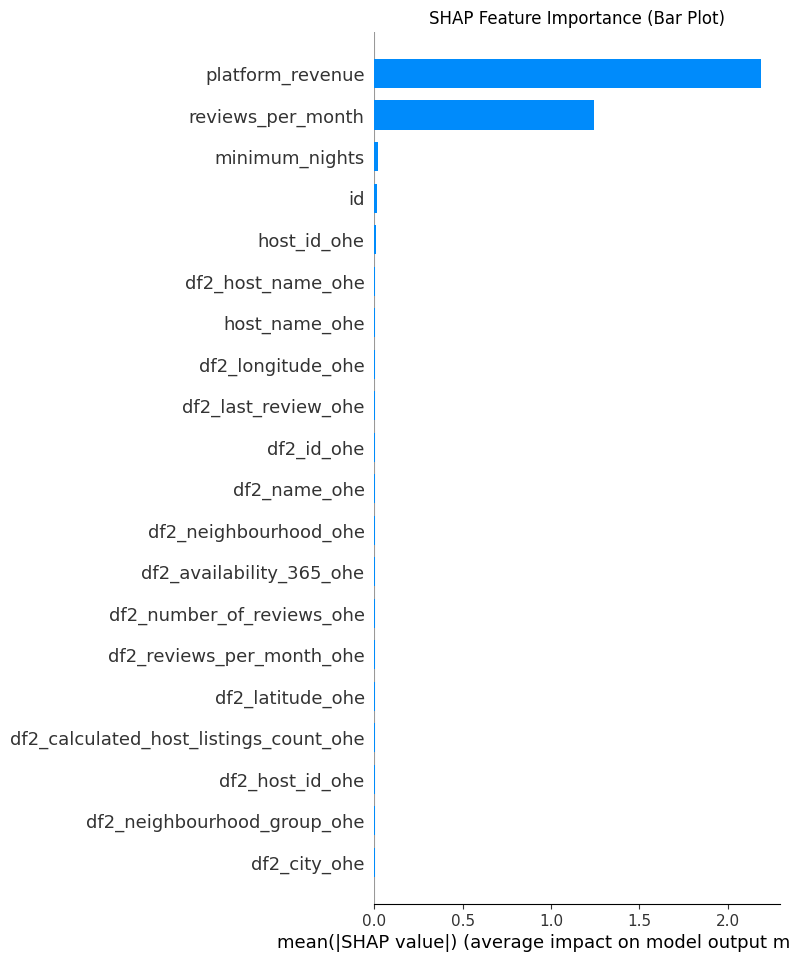

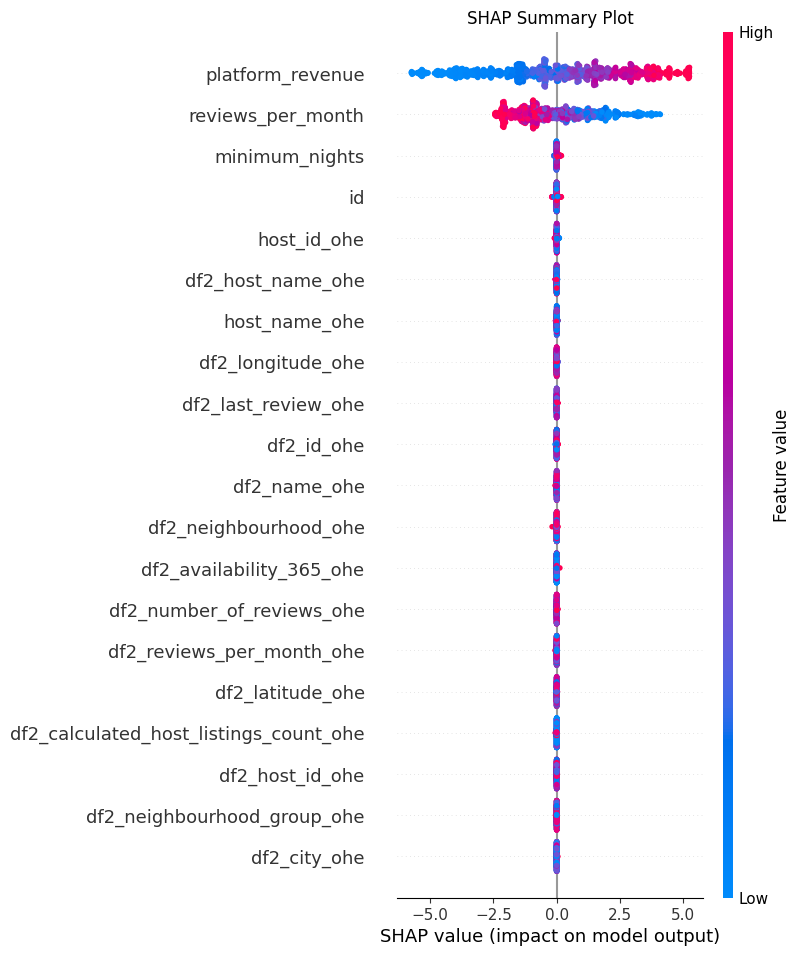

In [49]:
import shap
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder


# Convert PySpark DataFrame to pandas DataFrame
encoded_df_pandas = encoded_df.toPandas()

# Prepare the data
X = encoded_df_pandas.drop(columns=['review_rate_number'])
y = encoded_df_pandas['review_rate_number']

# Handle categorical variables and missing data
label_encoders = {}
for column in X.select_dtypes(include=['category', 'object']).columns:
    le = LabelEncoder()
    X[column] = le.fit_transform(X[column].astype(str))
    label_encoders[column] = le
X.fillna(0, inplace=True)

# Train a Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

# Explain the model's predictions using SHAP
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X)

# Plot SHAP summary plot (bar plot)
shap.summary_plot(shap_values, X, plot_type="bar", show=False)
plt.title('SHAP Feature Importance (Bar Plot)')
plt.show()

# Plot SHAP summary plot (detailed plot)
shap.summary_plot(shap_values, X, show=False)
plt.title('SHAP Summary Plot')
plt.show()

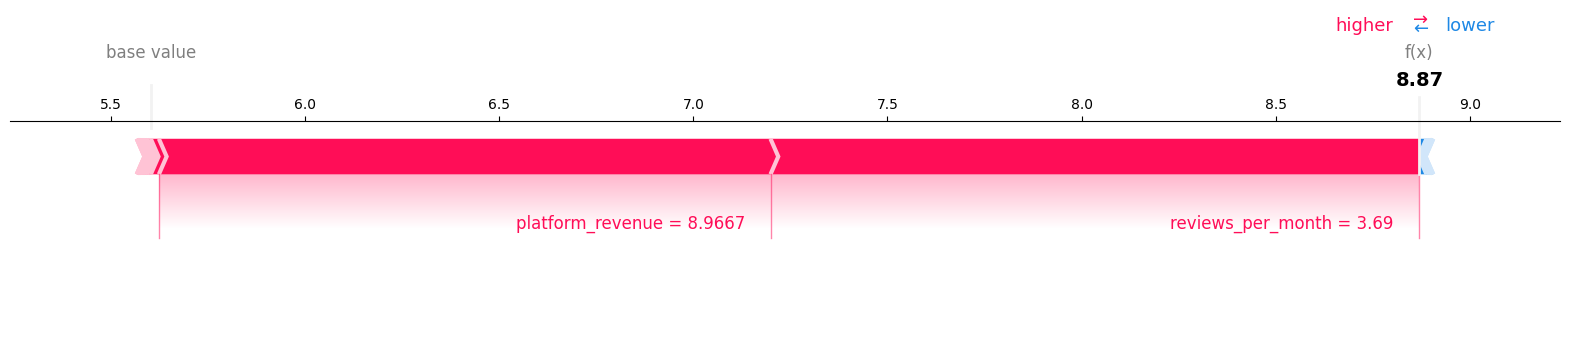

In [50]:
shap_values_single = explainer.shap_values(X.iloc[0])

shap.force_plot(explainer.expected_value, shap_values_single, X.iloc[0], matplotlib=True)


In [51]:
import numpy as np
# Get feature importance from SHAP values
shap_importance = pd.DataFrame({
    'feature': X.columns,
    'shap_importance': np.abs(shap_values).mean(axis=0)
}).sort_values(by='shap_importance', ascending=False)

# Extract the top 7 features
top_7_features = shap_importance['feature'].head(7).tolist()

print("Top 7 Features from SHAP:", top_7_features)


Top 7 Features from SHAP: ['platform_revenue', 'reviews_per_month', 'minimum_nights', 'id', 'host_id_ohe', 'df2_host_name_ohe', 'host_name_ohe']


In [52]:
start_time = time.time()
start_memory = psutil.virtual_memory().used / (1024 ** 3)
start_cpu = psutil.cpu_percent()

                          accuracy  weightedPrecision  weightedRecall  \
Logistic Regression       0.814961           0.825189        0.814961   
Random Forest Classifier  0.401575           0.739209        0.401575   
Decision Tree Classifier  0.503937           0.484573        0.503937   

                                f1  
Logistic Regression       0.816368  
Random Forest Classifier  0.422112  
Decision Tree Classifier  0.474825  


<Figure size 1200x800 with 0 Axes>

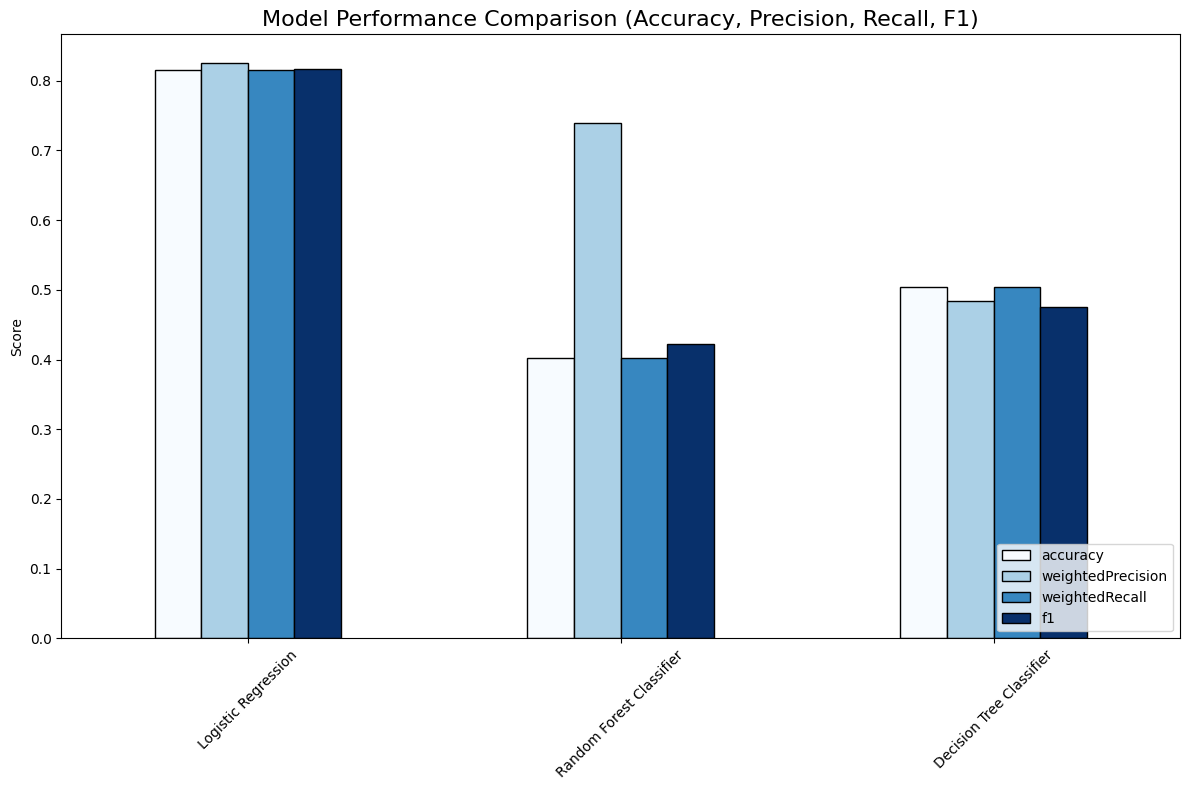

In [54]:
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StringIndexer, VectorAssembler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare the label column (convert it to numerical using StringIndexer if it's categorical)
indexer = StringIndexer(inputCol="review_rate_number", outputCol="indexed_label")
indexed_df = indexer.fit(encoded_df).transform(encoded_df)

# Assemble the feature columns using the top 7 features
assembler = VectorAssembler(inputCols=top_7_features, outputCol="features")
assembled_df = assembler.transform(indexed_df)

# Split the data into training (80%) and test sets (20%)
train_data, test_data = assembled_df.randomSplit([0.8, 0.2], seed=42)

# List of classification models to compare
classification_models = {
    "Logistic Regression": LogisticRegression(featuresCol="features", labelCol="indexed_label"),
    "Random Forest Classifier": RandomForestClassifier(featuresCol="features", labelCol="indexed_label", numTrees=100),
    "Decision Tree Classifier": DecisionTreeClassifier(featuresCol="features", labelCol="indexed_label")
}

# Initialize the evaluator for accuracy, precision, recall, and F1 score
metrics = ['accuracy', 'weightedPrecision', 'weightedRecall', 'f1']
evaluator = MulticlassClassificationEvaluator(labelCol="indexed_label", predictionCol="prediction")

# Dictionary to store the evaluation results for each model
results = {model_name: {} for model_name in classification_models}

# Train, predict, and evaluate each classification model
for model_name, model in classification_models.items():
    # Train the model on the training data
    trained_model = model.fit(train_data)

    # Make predictions on the test data
    predictions = trained_model.transform(test_data)

    # Evaluate using multiple metrics
    for metric in metrics:
        score = evaluator.evaluate(predictions, {evaluator.metricName: metric})
        results[model_name][metric] = score

# Convert results dictionary to DataFrame
performance_df = pd.DataFrame(results).T  # Transpose the dictionary for easier plotting

# Print results for reference
print(performance_df)

# Plotting the performance of models
plt.figure(figsize=(12, 8))
performance_df.plot(kind='bar', figsize=(12, 8), colormap='Blues', edgecolor='black')
plt.title("Model Performance Comparison (Accuracy, Precision, Recall, F1)", fontsize=16)
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


In [55]:
print(f"Model training time: {end_time - start_time:.2f} seconds")
print(f"Memory used for model training: {end_memory - start_memory:.2f} GB")
print(f"CPU usage after model training: {end_cpu:.2f}%")

Model training time: -541.07 seconds
Memory used for model training: -1.23 GB
CPU usage after model training: 99.90%
